In [392]:
import pickle
import numpy as np
import pandas as pd
import statsmodels.api as sm

from IPython.display import display
from tableone import TableOne
from scipy.stats import chi2_contingency, kruskal

import pyfpgrowth
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules

import statsmodels.formula.api as smf

from tqdm import tqdm
import time
import re
import random
from pymetamap import MetaMap
mm = MetaMap.get_instance('/home/qxw225/YihengWordCorrection/pym/public_mm20/bin/metamap20')

# Reference: https://towardsdatascience.com/tutorial-network-visualization-basics-with-networkx-and-plotly-and-a-little-nlp-57c9bbb55bb9
# Import packages for data visualization
import plotly.offline as py
import plotly.graph_objects as go
import networkx as nx
py.init_notebook_mode(connected=True) 

# Dataframe

In [337]:
# Load pickle
#demo = pickle.load(open('demo.pkl','rb'), encoding='latin1')
drug_map_rx = pickle.load(open('drug_map_rx.pkl','rb'), encoding='latin1')
indi_mapping = pickle.load(open('indi_mapping.pkl','rb'), encoding='latin1')
#reac = pickle.load(open('reac.pkl','rb'), encoding='latin1')

In [338]:
# rename columns
indi_mapping = indi_mapping.rename(columns = {'indi_drug_seq': 'drug_seq'})
#demo = demo[['primaryid','caseid','sex','age','age_cod','filename']]

# convert data type
drug_map_rx['drug_seq'] = drug_map_rx['drug_seq'].astype(int)
indi_mapping['drug_seq'] = indi_mapping['drug_seq'].astype(int)
drug_map_rx['caseid'] = drug_map_rx['caseid'].astype(int)
indi_mapping['caseid'] = indi_mapping['caseid'].astype(int)

In [219]:
indi_mapping.loc[indi_mapping['preferred_name'].str.contains('opium dependence'),'preferred_name']\
= 'opioid use disorder'

indi_mapping.loc[indi_mapping['preferred_name'].str.contains('drug dependence of morphine type'),'preferred_name']\
= 'opioid use disorder'

indi_mapping.loc[indi_mapping['preferred_name'].str.contains('opioid abuse'),'preferred_name']\
= 'opioid use disorder'

indi_mapping.loc[indi_mapping['preferred_name'].str.contains('opiate addiction'),'preferred_name']\
= 'opioid use disorder'

In [339]:
# clean up filename only keep time
#demo['filename'] = demo['filename'].str[4:8]
drug_map_rx['filename'] = drug_map_rx['filename'].str[4:8]
indi_mapping['filename'] = indi_mapping['filename'].str[4:8]
#reac['filename'] = reac['filename'].str[4:8]
#reac['filename'] = reac['filename'].str.lower()
#reac['pt'] = reac['pt'].str.lower()
#del drug_map_rx['drug_seq']
#del indi_mapping['drug_seq']

In [342]:
#demo = demo.set_index(['primaryid','filename','caseid'])
drug_map_rx = drug_map_rx.set_index(['primaryid','filename','caseid','drug_seq'])
indi_mapping = indi_mapping.set_index(['primaryid','filename','caseid','drug_seq'])
indi_mapping = indi_mapping[['preferred_name','sem_type']]
#reac = reac.set_index(['primaryid','filename'])

In [374]:
drug_indi = drug_map_rx.join(indi_mapping)
#drug_indi = drug_indi.reset_index()

In [381]:
drug_indi = drug_indi.reset_index().dropna()

In [383]:
drug_indi = drug_indi[['gn','preferred_name']]

In [388]:
x = drug_indi.groupby(['gn','preferred_name']).size().reset_index(name='Count')

In [391]:
x.to_csv('drug_indi_count.csv', index= False, sep = ';')

In [351]:
drug_indi = drug_indi.drop_duplicates()

In [353]:
drug_indi = drug_indi.dropna()

In [372]:
drug_indi.to_csv('drug_indication.csv', index= False, sep = ';')

In [355]:
group = drug_indi.groupby('gn')

df2 = group.apply(lambda x: x['preferred_name'].unique())

In [365]:
drug_indication = pd.DataFrame(df2)
drug_indication.columns=['indication'] 

In [371]:
drug_indi

,gn,preferred_name
6,infliximab,crohn disease
9,docetaxel,bronchogenic carcinoma
10,carboplatin,bronchogenic carcinoma
11,docetaxel,malignant neoplasm of stomach
12,irinotecan,malignant neoplasm of stomach
...,...,...
41119083,ferrous sulfate,malabsorption syndrome
41120076,fesoterodine,chronic kidney diseases
41120603,phenelzine,malaise
41121483,aripiprazole lauroxil,drug abuse


In [367]:
drug_indication.to_csv('drug_indication.csv')

In [222]:
drug_indi = drug_map_rx.join(indi_mapping, how = 'outer')
drug_indi = drug_indi.reset_index()
drug_indi = drug_indi.set_index(['caseid','primaryid','filename'])

demo_drug_indi = demo.join(drug_indi, how = 'left')
demo_drug_indi = demo_drug_indi.reset_index()
demo_drug_indi = demo_drug_indi.set_index(['primaryid','filename'])

demo_drug_indi_reac = demo_drug_indi.join(reac, how = 'left')
demo_drug_indi_reac = demo_drug_indi_reac.reset_index()


demo_drug_indi_reac = \
demo_drug_indi_reac[['primaryid','age','age_cod','sex','filename','gn','pt','preferred_name','sem_type']].\
rename(columns = {'pt':'reac_pt', 'preferred_name':'indi_pt'})

demo_drug_indi_reac = demo_drug_indi_reac.drop_duplicates()

In [333]:
drug_indi = drug_indi.rename(columns = { 'preferred_name':'indi_pt'})[['gn','indi_pt']]

In [336]:
indi_mapping

preferred_name sem_type
primaryid filename caseid                               
36059074  12q4     3605907  alzheimer's disease   [dsyn]
36177452  12q4     3617745  alzheimer's disease   [dsyn]
36916633  12q4     3691663  alzheimer's disease   [dsyn]
37326272  12q4     3732627  alzheimer's disease   [dsyn]
71536894  12q4     7153689  alzheimer's disease   [dsyn]
...                                         ...      ...
8620681   12q3     8743421         pericarditis   [dsyn]
                   8743421         pericarditis   [dsyn]
                   8743421         pericarditis   [dsyn]
                   8743421         pericarditis   [dsyn]
8624043   12q3     8747036           varicocele   [dsyn]

[15717926 rows x 2 columns]

In [335]:
drug_map_rx

drugname  \
primaryid filename caseid                                                   
34483284  12q4     3448328                                        sustiva   
645853011 12q4     6458530                                        sustiva   
68799198  12q4     6879919                                        sustiva   
                   6879919                                        sustiva   
711147111 12q4     7111471                                        sustiva   
...                                                                   ...   
8624961   12q3     7952972  magnesium                          /00430401/   
8624971   12q3     8427013                            lopraz (omeprazole)   
                   8427013                                epilin (epilim)   
8625461   12q3     8748182                                  roxitromycine   
8625564   12q3     8748260                           teva alendronic acid   

                                       name  tty             gn           rela  
primaryid filename caseid                                                       
34483284  12q4     3448328          sustiva   BN      efavirenz  has_tradename  
645853011 12q4     6458530          sustiva   BN      efavirenz  has_tradename  
68799198  12q4     6879919          sustiva   BN      efavirenz  has_tradename  
                   6879919          sustiva   BN      efavirenz  has_tradename  
711147111 12q4     7111471          sustiva   BN      efavirenz  has_tradename  
...                                     ...  ...            ...            ...  
8624961   12q3     7952972        magnesium   IN      magnesium             IN  
8624971   12q3     8427013       omeprazole   IN     omeprazole             IN  
                   8427013           epilim   BN      valproate  has_tradename  
8625461   12q3     8748182    roxithromycin   IN  roxithromycin             IN  
8625564   12q3     8748260  alendronic acid  PIN    alendronate       has_form  

[41035681 rows x 5 columns]

In [334]:
drug_indi

gn  \
caseid   primaryid   filename                     
5657190  4204616     04q1           misoprostol   
                     04q1              chymosin   
                     04q1      magnesium cation   
                     04q1          mifepristone   
5660304  4214534     04q1             oxycodone   
...                                         ...   
13825291 13825291110 20q2            octreotide   
                     20q2            octreotide   
                     20q2            metoprolol   
                     20q2            metoprolol   
                     20q2            metoprolol   

                                                        indi_pt  
caseid   primaryid   filename                                    
5657190  4204616     04q1                                   NaN  
                     04q1                                   NaN  
                     04q1                                   NaN  
                     04q1                                   NaN  
5660304  4214534     04q1                                   NaN  
...                                                         ...  
13825291 13825291110 20q2      carcinoid tumor no icd-o subtype  
                     20q2                               dyspnea  
                     20q2      carcinoid tumor no icd-o subtype  
                     20q2      carcinoid tumor no icd-o subtype  
                     20q2                               dyspnea  

[129743103 rows x 2 columns]

In [8]:
len(demo_drug_indi_reac['primaryid'].unique())

12190282

In [393]:
len(demo_drug_indi_reac['primaryid'].unique())

12190282

In [408]:
demo_drug_indi_reac

,primaryid,age,age_cod,sex,filename,gn,reac_pt,indi_pt,sem_type
0,4204616,21.0,yr,f,04q1,misoprostol,abdominal pain,NaN,NaN
1,4204616,21.0,yr,f,04q1,misoprostol,heart rate increased,NaN,NaN
2,4204616,21.0,yr,f,04q1,misoprostol,nausea,NaN,NaN
3,4204616,21.0,yr,f,04q1,misoprostol,pyrexia,NaN,NaN
4,4204616,21.0,yr,f,04q1,misoprostol,uterine tenderness,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1424220,1691755416,39.0,yr,f,20q2,dantrolene,hypotension,opioid use disorder,[mobd]
1424221,1691755416,39.0,yr,f,20q2,dantrolene,immune thrombocytopenia,opioid use disorder,[mobd]
1424222,1691755416,39.0,yr,f,20q2,dantrolene,platelet count decreased,opioid use disorder,[mobd]
1424223,1691755416,39.0,yr,f,20q2,dantrolene,skin ulcer,opioid use disorder,[mobd]


In [420]:
indi_average.columns = ['count']
indi_average[indi_average['count'] > 1]

,count
primaryid,
4261827,3
4261871,4
4261996,3
4262058,12
4262061,2
...,...
1769922810,2
1780052910,2
1780221611,4


In [421]:
indi_average

,count
primaryid,
4223542,1
4250482,1
4261823,1
4261824,1
4261825,1
...,...
1776671212,1
1780052910,2
1780221611,4


In [425]:
reac_average = demo_drug_indi_reac[['primaryid','reac_pt']].drop_duplicates().dropna()\
.groupby(['primaryid']).agg(['count'])

reac_average.mean()

reac_pt  count    3.000672
dtype: float64

In [409]:
indi_average = demo_drug_indi_reac[['primaryid','indi_pt']].drop_duplicates().dropna()\
.groupby(['primaryid']).agg(['count'])

indi_average.mean()

indi_pt  count    1.36943
dtype: float64

In [410]:
pair_average = demo_drug_indi_reac[['primaryid','gn','indi_pt']].dropna().drop_duplicates()

In [414]:
pair_average["pair"] = pair_average["gn"] + pair_average["indi_pt"]
pair_average = pair_average[['primaryid','pair']]
pair_average = pair_average.groupby(['primaryid']).agg(['count'])

In [415]:
pair_average

,pair
,count
primaryid,
4223542,2
4250482,1
4261823,2
4261824,2
4261825,8
...,...
1776671212,5
1780052910,24


In [416]:
pair_average.mean()

pair  count    6.342918
dtype: float64

In [411]:
drug_average.mean()

gn  count    2.910149
dtype: float64

In [426]:
drug_average.columns = ['count']
drug_average[drug_average['count'] > 1]

,count
primaryid,
4204616,4
4214534,2
4223542,2
4261823,2
4261824,2
...,...
1776625611,8
1776671212,5
1780052910,12


In [427]:
reac_average.columns = ['count']
reac_average[reac_average['count'] > 1]

,count
primaryid,
4204616,6
4214534,3
4223542,7
4250482,2
4261823,3
...,...
1772413910,17
1780052910,30
1780221611,3


# Opioid Cohort

In [224]:
# opioid vocabulary
opioid = ['Hydrocodone','Oxycodone', 'Hydromorphone','Fentanyl','Oxymorphone','Morphine','Codeine','Methadone',
          'Buprenorphine','Tramadol','Meperidine','heroin']
op = []
for x in opioid:
    gn = x.lower()
    op.append(gn)

# dependence  vocabulary
reac_dependence = ['drug dependence','polysubstance dependence', 'drug dependence, antepartum',\
                   'substance dependence','chemical abuser','substance abuse','drug abuse', 'substance abuser',\
                   'ex-drug abuser','polysubstance abuse','drug abuser']
indi_dependence = ['polysubstance dependence', 'drug dependence','dependence',
        'drug dependence of morphine type', 'opium dependence','drug use disorders',
       'substance use disorders','drug abuse', 'substance abuse problem']

op_cohort = list(indi_mapping[indi_mapping['preferred_name'].str.contains('opioid use disorder')]\
                 .reset_index()['primaryid'].unique())
op_cohort = op_cohort + list(demo_drug_indi_reac[demo_drug_indi_reac['gn'].isin(op) \
                                     & demo_drug_indi_reac['indi_pt'].isin(indi_dependence)]\
                 ['primaryid'].unique())
op_cohort = op_cohort + list(demo_drug_indi_reac[demo_drug_indi_reac['gn'].isin(op) \
                                     & demo_drug_indi_reac['reac_pt'].isin(reac_dependence)]\
                 ['primaryid'].unique())
op_cohort = list(set(op_cohort))

In [225]:
len(op_cohort)

57293

In [10]:
len(op_cohort)

57293

In [226]:
op_column = len(op_cohort)*['opioid use disorder']
op_sem = len(op_cohort)*['[mobd]']
# build new indication record
op_indication = pd.DataFrame(list(zip(op_cohort, op_column,op_sem)), 
               columns =['primaryid', 'indi_pt','sem_type']) 

In [227]:
a = demo_drug_indi_reac[['primaryid','age','age_cod','sex','filename','gn','reac_pt']].drop_duplicates()
a = pd.merge(a, op_indication)
demo_drug_indi_reac = pd.concat([demo_drug_indi_reac, a]).drop_duplicates()

# Useful Function 

In [228]:
# Yield successive n-sized 
# chunks from l. 
def divide_chunks(l, n):       
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
        
def process(drugname):
    
    pn_dict, cui_dict, sem_dict = {},{},{}
    #drug_list = [x.encode('ascii', 'ignore') for x in drugname]
    
    concept,error = mm.extract_concepts(drugname,list(range(0,len(drugname))),                                        
                                        restrict_to_sts=['acab', 'anab', 'comd', 'cgab','dsyn','emod','fndg',
                                                         'inpo', 'mobd', 'neop', 'patf','sosy'], 
                                        word_sense_disambiguation=True)
    pn_dict, cui_dict, sem_dict = get_concept(drugname, concept)
                  
                   
    return pn_dict, cui_dict, sem_dict

def get_concept(drugname, concept):
        
    pn_dict = {}
    cui_dict = {}
    sem_dict = {}
    drug_id = []
    
    for j in range(0, len(concept)):
        ind = getattr(concept[j], 'index')
        if ind == '-e 0':
            ind = '0'
        ind = int(ind)
        if ind not in drug_id:
            if 'preferred_name' in concept[j].__dir__():
                drug_id.append(ind)
                pn_dict[drugname[ind]] = getattr(concept[j], 'preferred_name')
                sem_dict[drugname[ind]] = getattr(concept[j], 'semtypes') 
                cui_dict[drugname[ind]] = getattr(concept[j], 'cui')
    return pn_dict, cui_dict, sem_dict

def get_pr_sem(drugname):
    n = 1000  
    x = list(divide_chunks(drugname, n)) 

    preferred_name = {}
    semtypes = {}
    cui = {}

    for i in tqdm(range(0, len(x))):
        start_time = time.time()
        pn_dict, cui_dict,sem_dict = process(x[i])
        preferred_name.update(pn_dict)
        semtypes.update(sem_dict)
        cui.update(cui_dict)
        print("[ Epoch " + str(i) + " ] total:" + str(len(preferred_name)) + " current:" + str(len(pn_dict)) + " takes %s seconds " % (time.time() - start_time))
        
    return preferred_name, cui, semtypes

In [229]:
def association(df):
# Association Rules Preparation
    fp = df.groupby('primaryid')['indi_pt'].apply(set)
    fp = pd.DataFrame(fp)
    fp['indi_pt'] = fp['indi_pt'].apply(list)
    fp_pn = list(fp['indi_pt'])
    
    te = TransactionEncoder()
    te_ary = te.fit(fp_pn).transform(fp_pn)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # fp-growth parameters:
    frequent_itemsets = fpgrowth(df, min_support=0.000002, use_colnames=True,max_len=3)

    rules = association_rules(frequent_itemsets,  metric="lift", min_threshold=1)
    

    rules = rules.rename(columns = {'antecedents':'dis1_UMLS','consequents':'dis2_UMLS'})
    rules['dis1_UMLS'] = rules['dis1_UMLS'].apply(list)
    rules['dis2_UMLS'] = rules['dis2_UMLS'].apply(list)
    # association = rules.copy(deep=True)
    disease_rules = rules.explode('dis1_UMLS').explode('dis2_UMLS')[['dis1_UMLS','dis2_UMLS']].drop_duplicates()
    #op_rules = disease_rules[disease_rules['dis1_UMLS'] =='opiate addiction']
    return disease_rules

In [230]:
def ru(df):
# Association Rules Preparation
    fp = df.groupby('primaryid')['indi_pt'].apply(set)
    fp = pd.DataFrame(fp)
    fp['indi_pt'] = fp['indi_pt'].apply(list)
    fp_pn = list(fp['indi_pt'])
    
    te = TransactionEncoder()
    te_ary = te.fit(fp_pn).transform(fp_pn)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # fp-growth parameters:
    frequent_itemsets = fpgrowth(df, min_support=0.000002, use_colnames=True,max_len=3)

    rules = association_rules(frequent_itemsets,  metric="lift", min_threshold=1)
    

    rules = rules.rename(columns = {'antecedents':'dis1_UMLS','consequents':'dis2_UMLS'})
    rules['dis1_UMLS'] = rules['dis1_UMLS'].apply(list)
    rules['dis2_UMLS'] = rules['dis2_UMLS'].apply(list)

    return rules

In [231]:
def op_association(df):
# Association Rules Preparation
    fp = df.groupby('primaryid')['indi_pt'].apply(set)
    fp = pd.DataFrame(fp)
    fp['indi_pt'] = fp['indi_pt'].apply(list)
    fp_pn = list(fp['indi_pt'])
    
    te = TransactionEncoder()
    te_ary = te.fit(fp_pn).transform(fp_pn)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = fpgrowth(df, min_support=0.000002, use_colnames=True,max_len=3)

    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

    rules = rules.rename(columns = {'antecedents':'dis1_UMLS','consequents':'dis2_UMLS'})
    rules['dis1_UMLS'] = rules['dis1_UMLS'].apply(list)
    rules['dis2_UMLS'] = rules['dis2_UMLS'].apply(list)
    disease_rules = rules.explode('dis1_UMLS').explode('dis2_UMLS')[['dis1_UMLS','dis2_UMLS']].drop_duplicates()

    op_rules = disease_rules[disease_rules['dis1_UMLS'] =='opioid use disorder']
    return op_rules

# Whole population

## Association Rules Mining

In [233]:
indi = demo_drug_indi_reac[['primaryid','indi_pt']].dropna(subset = ['indi_pt']).drop_duplicates()
op_column = len(op_cohort)*['opioid use disorder']
# build new indication record
op_indication = pd.DataFrame(list(zip(op_cohort, op_column)), 
               columns =['primaryid', 'indi_pt']) 
indi_new = pd.concat([op_indication, indi]).drop_duplicates()
indi_new = indi_new.dropna(subset = ['indi_pt'])

In [234]:
disease_rules = association(indi_new)
op_rules = op_association(indi_new)
association_list = list(op_rules['dis2_UMLS'])
association_list.append('opioid use disorder')
network = disease_rules[(disease_rules['dis1_UMLS'].isin(association_list))&(disease_rules['dis2_UMLS'].isin(association_list))]
#node_count = dict(network['dis1_UMLS'].value_counts())
#preferred_name, cui, typ = get_pr_sem(association_list)

In [ ]:
x = ru(indi_new)

x['dis1_UMLS'] = x['dis1_UMLS'].apply(set)
x['dis2_UMLS'] = x['dis2_UMLS'].apply(set)

#y = x[x['dis1_UMLS'] == {'opioid use disorder'}]

In [289]:
#y = x[x['dis1_UMLS'] == {'opioid use disorder'}]
mask = x.dis1_UMLS.apply(lambda i: 'opioid use disorder' in i)
od = x[mask]
od

,dis1_UMLS,dis2_UMLS,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7890,"[opioid use disorder, pain in limb]",[back pain],0.000015,0.007651,0.000003,0.208333,27.230565,3.029132e-06,1.253494
7891,"[opioid use disorder, back pain]",[pain in limb],0.000137,0.002109,0.000003,0.022915,10.863780,2.855154e-06,1.021293
7893,[opioid use disorder],"[pain in limb, back pain]",0.007207,0.000320,0.000003,0.000436,1.363623,8.385401e-07,1.000116
7896,"[opioid use disorder, pain]",[pain in limb],0.000846,0.002109,0.000004,0.004756,2.254913,2.240066e-06,1.002660
7897,"[opioid use disorder, pain in limb]",[pain],0.000015,0.033970,0.000004,0.266667,7.850124,3.512360e-06,1.317314
...,...,...,...,...,...,...,...,...,...
584458,"[opioid use disorder, pain]",[drug use disorders],0.000846,0.000482,0.000008,0.009661,20.064499,7.768507e-06,1.009269
584460,[opioid use disorder],"[pain, drug use disorders]",0.007207,0.000010,0.000008,0.001135,117.136956,8.106194e-06,1.001126
584462,"[opioid use disorder, mental depression]",[drug use disorders],0.000167,0.000482,0.000007,0.042137,87.511269,6.963440e-06,1.043488
584464,[opioid use disorder],"[mental depression, drug use disorders]",0.007207,0.000013,0.000007,0.000977,77.706854,6.953285e-06,1.000966


In [292]:
z = []
for i in od['dis2_UMLS']:
    z = z + i

for i in od['dis1_UMLS']:
    z = z + i
    
z = list(set(z))

z

['mood disorders',
 'epilepsy',
 'drug use disorders',
 'diabetic neuropathies',
 'narcolepsy',
 'thyroid diseases',
 'panic attacks',
 'benign prostatic hyperplasia',
 'fever',
 'substance withdrawal syndrome',
 'spasm',
 'traumatic and/or non-traumatic injury',
 'erectile dysfunction',
 'dependence',
 'neuralgia',
 'panic disorder',
 'alcohol or other drugs use',
 'hypersensitivity',
 'nicotine dependence',
 'cataplexy',
 'asthma',
 'ankle fracture',
 'chronic obstructive airway disease',
 'abdominal pain',
 'intentional self-injury',
 'pregnancy exposure',
 'hepatitis c, chronic',
 'agnosia for pain',
 'heart diseases',
 'anemia',
 'psychotic disorders',
 'obsessive-compulsive disorder',
 'drug withdrawal syndrome',
 'pelvic pain female',
 'substance abuse problem',
 'alcohol abuse',
 'arthralgia',
 'vomiting',
 'degenerative polyarthritis',
 'hypothyroidism',
 'hiv infections',
 'gastroesophageal reflux disease',
 'restless legs syndrome',
 'major depressive disorder',
 'pain, proc

In [293]:
len(z)

111

In [236]:
print('We extracted ' + str(len(x)) + ' rules in total.')

We extracted 585362 rules in total.


In [237]:
len(association_list)

106

In [156]:
association_list

['back pain',
 'pain in limb',
 'pain',
 'anxiety disorders',
 'constipation',
 'mental depression',
 'gastroesophageal reflux disease',
 'hypertensive disease',
 'benign prostatic hyperplasia',
 'sleeplessness',
 'hepatitis c',
 'hiv infections',
 'migraine disorders',
 'hypothyroidism',
 'arthritis',
 'attention deficit hyperactivity disorder',
 'bipolar disorder',
 'asthma',
 'diabetes mellitus',
 'epilepsy',
 'schizophrenia',
 'chronic obstructive airway disease',
 'drug dependence',
 'nausea',
 'neuropathy',
 'thyroid diseases',
 'sleep disorders',
 'headache',
 'major depressive disorder',
 'psychotic disorders',
 'pneumonia',
 'erectile dysfunction',
 'neuralgia',
 'fibromyalgia',
 'seizures',
 'dyspepsia',
 'anemia',
 'heart diseases',
 'vomiting',
 'deep vein thrombosis',
 'spasm',
 'arthralgia',
 'edema',
 'hepatitis c, chronic',
 'abdominal pain',
 'spinal fractures',
 'restless legs syndrome',
 'agitation',
 'generalized anxiety disorder',
 'post-traumatic stress disorder',

In [294]:
y = ['depression, psychotic', 
     'substance abuse problem', 
     'mental disorders', 
     'hepatitis c, chronic', 
     'drug use disorders', 
     'depression suicidal', 
     'mixed anxiety and depressive disorder', 
     'alcohol or other drugs use', 'schizophrenia', 
     'traumatic and/or non-traumatic injury', 
'hiv infections', 
     'attention deficit hyperactivity disorder',
 'intentional self-injury', 
     'post-traumatic stress disorder', 
'pain', 
'substance withdrawal syndrome', 
     'mood disorders', 
'polysubstance dependence', 
'sleeplessness', 
     'generalized anxiety disorder', 
     'personality disorders',
 'nicotine dependence', 
     'depression, bipolar',
 'alcohol abuse', 
     'panic attacks', 
'chronic anxiety', 
'dependence',
'sleep disorders',
 'pain, procedural',
'mental depression', 
'anxiety state', 
'breakthrough pain', 
'depression, postpartum',
 'drug withdrawal syndrome', 
  'seizures', 'panic disorder',
     'substance use disorders',
 'anxiety',
 'obsessive-compulsive disorder', 
'major depressive disorder',
 'epilepsy', 
'agitation',  
'drug abuse',
 'chronic pain', 
     'chronic depression', 
 'anxiety disorders',
'psychotic disorders', 
'hepatitis c', 
'depression, neurotic', 
     'bipolar disorder','social anxiety', 
    'complex regional pain syndromes',
 'drug dependence']


y = y + [

 'pain',
 'anxiety disorders',
 'drug dependence',

 'generalized anxiety disorder',

 'mental disorders',
 'panic attacks',


 'drug overdose',

 'sleep disorders',
 'personality disorders',
 'drug withdrawal syndrome',
 'panic disorder',


 'dependence',
 'polysubstance dependence',

 'nicotine dependence',
 
 'intentional self-injury',

 'substance withdrawal syndrome',
 'toxic effect',

 'complex regional pain syndromes',
 'pain, procedural',
 'breakthrough pain',
 'substance abuse problem',

 'drug abuse',
 'alcohol abuse',
 'alcohol or other drugs use',
 'drug use disorders',
 'substance use disorders']

y = list(set(y))

In [295]:
er = []
for i in z:
    if i in y:
        er.append(i)
        
len(er),len(set(y))

(43, 55)

In [296]:
len(er)/len(z), len(er)/len(y)

(0.38738738738738737, 0.7818181818181819)

In [297]:
x['dis'] = x['dis1_UMLS'] + x['dis2_UMLS']


In [299]:
x['dis1'] = x['dis']

In [303]:
disease_pair = x[['dis', 'dis1']]
disease_pair = disease_pair.explode('dis').explode('dis1').drop_duplicates()

In [305]:
disease_pair = disease_pair[disease_pair['dis'] != disease_pair['dis1']]

In [310]:
disease_pair.columns = ['dis1_UMLS','dis2_UMLS']
disease_pair

,dis1_UMLS,dis2_UMLS
0,hypertensive disease,crohn disease
0,hypertensive disease,diabetes mellitus
0,crohn disease,hypertensive disease
0,crohn disease,diabetes mellitus
0,diabetes mellitus,hypertensive disease
...,...,...
585340,fever,covid-19
585350,covid-19,hypertensive disease
585350,hypertensive disease,covid-19
585356,covid-19,pain


In [328]:
64350/2

32175.0

In [329]:
len(disease_pair['dis1_UMLS'].unique())

1916

In [311]:
disease_pair.to_csv('disease_pair.csv', index = False)

In [312]:
rank = pd.read_csv('/home/qxw225/YihengWordCorrection/pyrwr/rank.csv')
#rank = pd.read_csv('/home/qxw225/YihengWordCorrection/pyrwr/untitled.txt')
di = list(rank['disease'].unique())

In [313]:
indi_pt = list(indi_mapping['preferred_name'].unique())

In [314]:
d = []
for i in indi_pt:
    if i not in di:
        d.append(i)

In [315]:
d_column = len(d)*[0]
ind = pd.DataFrame(list(zip(d, d_column)), 
               columns =['disease','score']) 

In [316]:
score = pd.concat([ind,rank],axis = 0)
score['truth'] = np.where(score['disease'].isin(y), 1, 0)

In [317]:
score = score.sort_values(by=['score'], ascending = False)

In [318]:
import numpy as np
decile = np.array_split(score, 10)

In [319]:
parts = []
marker = 0
for i in range(10):
    x = round(marker + 0.1, 1)
    part = [marker, x]
    marker=x
    parts.append(part)
parts

[[0, 0.1],
 [0.1, 0.2],
 [0.2, 0.3],
 [0.3, 0.4],
 [0.4, 0.5],
 [0.5, 0.6],
 [0.6, 0.7],
 [0.7, 0.8],
 [0.8, 0.9],
 [0.9, 1.0]]

In [320]:
x = []
y = []
for i in range(10):
    z = decile[i]
    print(parts[i][1], len(z[z['truth'] == 1]))
    x.append(str(parts[i][1]))
    y.append(len(z[z['truth'] == 1]))

0.1 43
0.2 1
0.3 1
0.4 0
0.5 0
0.6 2
0.7 5
0.8 3
0.9 0
1.0 0


In [321]:
len(x),len(y)

(10, 10)

In [322]:
x = ['0-10%','10%-20%','20%-30%','30%-40%','40%-50%','50%-60%','60%-70%','70%-80%','80%-90%','90-100%']

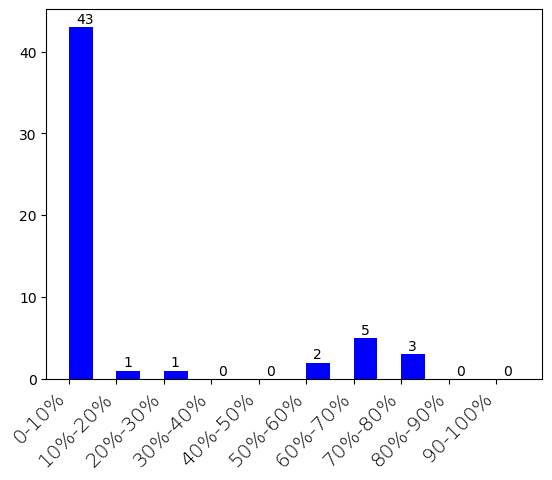

In [323]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
plt.bar(x, y, color = 'blue', align='edge', width=0.5)
#plt.set_xticks(x)
#plt.bar(range(len(my_dict)), my_dict.values(), align='center')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
for i in range(len(x)):
    plt.annotate(y[i], xy = (i+0.15, y[i]+0.5))
plt.show()

In [144]:
op_rules.to_csv('association_list.csv')

In [151]:
disease_rules.to_csv('disease_rules.csv', index = False)

In [153]:
len(disease_rules['dis1_UMLS'].unique())

1916

In [154]:
disease_rules

,dis1_UMLS,dis2_UMLS
0,hypertensive disease,diabetes mellitus
0,crohn disease,diabetes mellitus
1,diabetes mellitus,hypertensive disease
1,crohn disease,hypertensive disease
2,hypertensive disease,crohn disease
...,...,...
585341,fever,covid-19
585351,covid-19,hypertensive disease
585352,hypertensive disease,covid-19
585357,covid-19,pain


In [ ]:
rules.to_csv('DCN_Faers_2020.csv', index = False)

### Network Visualization

In [ ]:
ty = indi_mapping[['preferred_name','sem_type']].drop_duplicates()
op_ty = ty[ty['preferred_name'].isin(association_list)]
network = network[['dis1_UMLS','dis2_UMLS']].drop_duplicates()
net = pd.merge(network,op_ty, left_on = 'dis1_UMLS', right_on = 'preferred_name').iloc[:, [0,1,3]].rename(columns = {'sem_type':"sem_type_1"})
net = pd.merge(net,op_ty, left_on = 'dis2_UMLS', right_on = 'preferred_name').iloc[:, [0,1,2,4]].rename(columns = {'sem_type':"sem_type_2"})
net.to_csv('network.csv', index = False)
net.to_csv('network.txt', index = False,sep=';')

## Prevalence

### Table one

In [ ]:
print('There are ' + str(len(demo_drug_indi_reac['primaryid'].unique())) + ' original patients')
data_clean = demo_drug_indi_reac[demo_drug_indi_reac.age != 'nan']
data_clean = data_clean[data_clean.age_cod != 'nan']
data_clean = data_clean[data_clean.age != 'u']
data_clean = data_clean[data_clean.age != 'few']
print('Remove the missing age, There are ' + str(len(data_clean['primaryid'].unique())) + ' patients remaining')

data_clean = data_clean[data_clean.sex != 'nan']
# print('Remove the missing sex, There are ' + str(len(data_clean['primaryid'].unique())) + ' patients')

data_clean['age'] = data_clean['age'].astype(float)

#data_clean = data_clean.dropna(subset = ['indi_pt'])
data_clean['age'] = data_clean.apply(set_age_unit, axis=1)
data_clean['op'] = np.where(data_clean['primaryid'].isin(op_cohort), 1, 0)

data_clean = data_clean[~data_clean['sex'].isin(['p','i','t'])]
print('Remove the missing sex, There are ' + str(len(data_clean['primaryid'].unique())) + ' patients remaining')

data_clean['female'] = np.where(data_clean['sex'] == 'f', 1, 0)
data_clean = data_clean.drop(['sex'], axis=1)
data_clean['age'] = data_clean['age'].astype(float)

In [ ]:
table_one = data_clean[['primaryid','female','op','age']].drop_duplicates()
columns = ['age', 'female']
categorical = ['female']
groupby = 'op'
nonnormal = ['age']
display(TableOne(table_one, columns, categorical, groupby, nonnormal,
                 labels = {'op' : 'opioid addiction'},
                 pval=True, isnull=False, label_suffix=True))

### Top ranking

In [ ]:
indi_mapping = indi_mapping.reset_index()
indi_rank = indi_mapping[indi_mapping['primaryid'].isin(op_cohort)]\
[['primaryid','preferred_name']].drop_duplicates()

indi_rank['preferred_name'].value_counts().rename_axis('comorbidity').\
reset_index(name='counts').to_csv('indi_rank.csv')

len(indi_rank['preferred_name'].value_counts())

In [ ]:
top_rank = indi_rank['preferred_name'].value_counts().rename_axis('comorbidity').reset_index(name='counts')
top_rank

In [ ]:
list(top_rank['comorbidity'].unique())

In [ ]:
x = ['drug dependence',
 'pain nos, ctcae',
 'drug abuse',
 'drug use disorders',

 'mental depression',
 'anxiety',
 'back pain',
 'substance abuse problem',
 'insomnia, ctcae 3.0',
 'hypertension, ctcae',
 'dependence',
 'sleep disorders',
 'hepatitis c',
 'nicotine dependence',
 'drug withdrawal syndrome',
 'neuralgia',
 'fibromyalgia',
 'nausea, ctcae 3.0',
 'bipolar disorder',
 'gastroesophageal reflux disease',
 'migraine disorders',
 'arthralgia',
 'hiv infections',
 'breakthrough pain',
 'attention deficit hyperactivity disorder',
 'diabetes mellitus',
 'headache',
 'misuse',
 'schizophrenia',
 'asthma',
 'pain, procedural',
 'abdominal pain',
 'back injuries',
 'hepatitis c, chronic',
 'neuropathy',
 'pain in limb',
 'tobacco user',
 'arthritis',
 'constipation, ctcae',
 'narcolepsy',
 'epilepsy',
 'spasm',
 'alcohol abuse',
 'neck pain, ctcae 3.0',
 'alcohol or other drugs use',
 'traumatic and/or non-traumatic injury',
 'rheumatoid arthritis',
 'chronic obstructive airway disease',
 'alcoholic intoxication, chronic',
 'cancer pain',
 'abnormal',
 'psychotic disorders',
 'degenerative polyarthritis',
 'multiple sclerosis',
 'dyspepsia',
 'vomiting, ctcae',
 'mood disorders',
 'panic attacks',

 'decreasing',
 'substance use disorders',
 'major depressive disorder',
 'anemia',
 'anxiety disorders',
 'seizure, ctcae 3.0',
 'heart diseases',
 'musculoskeletal pain',
 'restless legs syndrome',

 'osteoporosis',
 'cataplexy',
 'seizures',
 'mental disorders',
 'substance withdrawal syndrome',
 'post-traumatic stress disorder',

 'thyroid diseases',
 'nerve injury',
 'back disorder',
 'drug overdose',
 'suicide attempt',
 'intervertebral disc degeneration',

 'polysubstance dependence',

 'myalgia',
 'joint injury',
 'diarrhea',
 'blood pressure finding',

 'panic disorder',

 
 'stress',
 'pneumonia',
 'generalized anxiety disorder',
 'sciatica',
 
 'limb injury',
 'erectile dysfunction, ctcae',
 'dyspnea, ctcae',
 'cough, ctcae',

 'abdominal discomfort',
 'toothache',
 'pruritus, ctcae',
 'pelvic pain',
 'fever',
 'pulmonary hypertension, ctcae',
 'bipolar i disorder',
 'inflammation',
 'encounter due to hormone replacement therapy',
 'stomach diseases',
 'chest pain',
 'body fluid retention',
 'irritable bowel syndrome',
 'athletic injuries',
 'gastrointestinal diseases',
 'obsessive-compulsive disorder',
 'gout',
 'gastric ulcer',
 'arthritis, psoriatic',
 'heart failure',
 'intentional self-injury',

 'drowsiness',

 'complex regional pain syndromes',
 'upper respiratory infections',


 'trigeminal neuralgia',

 'parkinson disease',


 'bone pain, ctcae 3.0',

 'spinal diseases',

 'schizoaffective disorder',

 'atrial fibrillation',
 'ankle fracture',

 'spinal fractures',
 'neck injuries',
 'personality disorders',
 'aspiration pneumonia',
 'multiple myeloma',
 'nasal congestion (finding)',

 'cluster headache',

 'osteoarthritis, spine',
 'discomfort',
 'gastritis, ctcae',


 'fatigue',


 'tremor, ctcae 3.0',

 'muscle spasticity',
 'mood swings',
 'angina pectoris',
 'tobacco use disorder',
 'eruptions',
 'alcohol withdrawal syndrome',

 
 'opiate addiction',
 'dental abscess',
 'abnormal behavior',
 'arthropathy',
 'bacterial infections',
 'spinal cord injuries',

 'borderline personality disorder',

 'bone diseases',
 'schizophreniform disorders',


 'depressed mood',
 'neural tube defects',
 'facial pain',


 'tendinitis',

 'hallucinations',


 'nervous system disorder',
 'cardiovascular event',

 'nervousness']
 

In [ ]:
y= ['drug dependence',
 'pain',
 'drug abuse',
 'drug use disorders',
 'anxiety disorders',
 'mental depression',
 'back pain',
 'substance abuse problem',
 'sleeplessness',
 'hypertensive disease',
 'dependence',
 'sleep disorders',
 'hepatitis c',
 'nicotine dependence',
 'drug withdrawal syndrome',
 'neuralgia',
 'fibromyalgia',
 'nausea',
 'bipolar disorder',
 'gastroesophageal reflux disease',
 'migraine disorders',
 'arthralgia',
 'hiv infections',
 'breakthrough pain',
 'attention deficit hyperactivity disorder',

 'headache',
 'schizophrenia',
 'asthma',
 'pain, procedural',
 'abdominal pain',
 'back injuries',
 'hepatitis c, chronic',
 'pain in limb',
 'neuropathy',
 'arthritis',
 'constipation',
 'narcolepsy',
 'epilepsy',
 'spasm',
 'alcohol abuse',
 'seizures',
 'neck pain',
 'alcohol or other drugs use',
 'traumatic and/or non-traumatic injury',
 'rheumatoid arthritis',
 'hypothyroidism',
 'chronic obstructive airway disease',

 'cancer pain',
 'psychotic disorders',
 'degenerative polyarthritis',

 'vomiting',

 'dyspepsia',
 'mood disorders',
 'panic attacks',

 'substance use disorders',

 'major depressive disorder',
 'heart diseases',
 'restless legs syndrome',
 'pregnancy exposure',
 
 'osteoporosis',
 'mental disorders',
 'substance withdrawal syndrome',
 'post-traumatic stress disorder',

 'nerve injury',
 'drug overdose',
 'back disorder',
 'suicide attempt',
 'polysubstance dependence',

 'communicable diseases',

 'myalgia',
 'joint injury',
 'diarrhea',
 'hyperlipidemia',

 'panic disorder',

 'generalized anxiety disorder',
 'limb injury',
 'sciatica',

 'benign prostatic hyperplasia',
 'erectile dysfunction',

 'pelvic pain female',
 'toothache',

 'abdominal discomfort',
 'pulmonary hypertension',
 'bipolar i disorder',

 'stomach diseases',
 'chest pain',

 'gastrointestinal diseases',

 'idiopathic pulmonary arterial hypertension',
 'obsessive-compulsive disorder',
 'gout',
 'arthritis, psoriatic',
 'gastric ulcer',

 'multiple allergies',
 'heart failure',
 'intentional self-injury',
 'somnolence',

 'complex regional pain syndromes',
 'endometriosis',

 'upper respiratory infections',


 'trigeminal neuralgia',
 'parkinson disease',
 'bone pain',

 'agnosia for pain',
 'personality disorders',

 'spinal fractures',
 'ulcer',

 'schizoaffective disorder',
 'ankle fracture',
 'neck injuries',
 'cluster headache',


 'fatigue',
 'wheezing',
 'tremor',
 'thrombosis of blood vessel',

 
 'angina pectoris',
 'muscle spasticity',
 'mood swings',
 'abnormal behavior',

 'spinal cord injuries',
 'vertigo',

 'opioid use disorder',
 'dental abscess',
 'alcohol withdrawal syndrome',
 'depressed mood',
 'neural tube defects',
 'bronchospasm',
 'neoplastic disease',
 'spinal canal stenosis',
 'schizophreniform disorders',
 'carpal tunnel syndrome',
 'rotator cuff syndrome',
 'bone diseases',

 'tendinitis',

 'craniocerebral trauma',
 'facial pain',
 'borderline personality disorder',

 'nervousness',

 'tension',
 'acquired immunodeficiency syndrome',

 'phobia, social',
 
 'paranoia',
 'postherpetic neuralgia',

 'initial insomnia',

 'anemia, sickle cell',
 'rectal pain']

In [ ]:
len(y)

In [ ]:
len(indi_mapping[indi_mapping['sem_type'] == '[dsyn]']['preferred_name'].unique())

In [ ]:
len(indi_mapping['preferred_name'].unique())

### Multivariant Logistic Regression

In [ ]:
DF = pd.DataFrame()
comorbidity = []
demo_indi_lr = demo_indi[['primaryid','female','op','age','indi_pt']].drop_duplicates()
for disease in list(top_rank['comorbidity']):
    if disease == 'opiate addiction':
        continue
    print('======================' + disease + '=======================')
    p = table(disease)
    if not isinstance(p, type(None)):
        DF = DF.append(p,ignore_index=True)
        comorbidity.append(disease)
        DF.index = comorbidity
DF

### MLR on HYPO

In [ ]:
sud = list(data_clean[data_clean['reac_pt'].str.contains('addiction',na=False)]['reac_pt'].unique())
sud = sud + list(data_clean[data_clean['indi_pt'].str.contains('addiction',na=False)]['indi_pt'].unique())

sud = sud + list(data_clean[data_clean['reac_pt'].str.contains('abuse',na=False)]['reac_pt'].unique())
sud = sud + list(data_clean[data_clean['indi_pt'].str.contains('abuse',na=False)]['indi_pt'].unique())

sud = sud + list(data_clean[data_clean['reac_pt'].str.contains('dependence',na=False)]['reac_pt'].unique())
sud = sud + list(data_clean[data_clean['indi_pt'].str.contains('dependence',na=False)]['indi_pt'].unique())

sud = sud + list(data_clean[data_clean['reac_pt'].str.contains('use disorder',na=False)]['reac_pt'].unique())
sud = sud + list(data_clean[data_clean['indi_pt'].str.contains('use disorder',na=False)]['indi_pt'].unique())

sud

In [ ]:
demo_indi_hypo = data_clean[['primaryid','female','op','age','gn','indi_pt','sem_type','reac_pt']].drop_duplicates()

#demo_indi_hypo = demo_indi_hypo[demo_indi_hypo['primaryid'].isin(n)]

demo_indi_hypo['indi_pt'] = demo_indi_hypo['indi_pt'].fillna(0)
demo_indi_hypo['gn'] = demo_indi_hypo['gn'].fillna(0)
demo_indi_hypo['reac_pt'] = demo_indi_hypo['reac_pt'].fillna(0)

# pain-related
# pain = list(demo_indi_hypo[demo_indi_hypo['indi_pt'].str.contains('pain',na=False)]['indi_pt'].unique())
demo_indi_hypo['pain'] = np.where(demo_indi_hypo['indi_pt'].str.contains( 'pain exacerbated',na=False)|\
                                  demo_indi_hypo['reac_pt'].str.contains( 'pain exacerbated',na=False), 1, 0)

# mental
demo_indi_hypo['mental'] = np.where(demo_indi_hypo['sem_type'] == '[mobd]', 1, 0)
#men = ['mental depression', 'anxiety']
#demo_indi_hypo['mental'] = np.where(demo_indi_hypo['indi_pt'].isin(men), 1, 0)

# autoimmune disease
immu = ['autoimmune thyroid disease','autoimmune thyroiditis']
demo_indi_hypo['immu'] = np.where(demo_indi_hypo['indi_pt'].isin(immu), 1, 0)

#radialogy therapy
#radi = list(demo_indi_hypo[demo_indi_hypo['indi_pt'].str.contains('radiation')]['indi_pt'].unique())
demo_indi_hypo['radi'] = np.where(demo_indi_hypo['indi_pt'].str.contains('radiation',na=False), 1, 0)

#iodine intake
#iodine = list(demo_indi_hypo[demo_indi_hypo['gn'].str.contains('iodine')]['gn'].unique())
demo_indi_hypo['iodine'] = np.where(demo_indi_hypo['gn'].str.contains('iodine',na=False), 1, 0)

# hypertension
demo_indi_hypo['ht'] = np.where(demo_indi_hypo['indi_pt'].str.contains('hypertension',na=False), 1, 0)

# SUD
sud = ['alcohol or other drugs use',
       
       'drug dependence', 'dependence', 'nicotine dependence',
       'polysubstance dependence', 
       'substance dependence', 'oxygen dependence',
      
      'opiate addiction',
       
      'drug dependence', 'nicotine dependence', 'dependence',
       'polysubstance dependence', 'drug dependence, antepartum',
       'substance dependence', 'device dependence', 'steroid dependence',
       
       'polysubstance abuse', 
       'substance abuse problem', 'abuse of laxatives',
       'drug abuse', 'alcohol abuse',
       
       'polysubstance abuse', 'drug abuser', 'tobacco abuse', 
       'neonatal complications of substance abuse', 'laxative abuse',
       'chemical abuser',  'substance abuse', 'drug abuse', 'alcohol abuse', 'substance abuser',
       'ex-drug abuser', 'antabuse implant' ]

sud1 = ['drug dependence']
demo_indi_hypo['sud'] = np.where((demo_indi_hypo['indi_pt'].isin(sud))|\
(demo_indi_hypo['reac_pt'].isin(sud)), 1, 0)

#demo_indi_hypo = demo_indi_hypo[['primaryid', 'female', 'op', 'age', 'indi_pt','pain','mental', 'immu', 'radi','sud','iodine','ht']]

# throid surgery
demo_indi_hypo

In [ ]:
demo_indi_hypo[demo_indi_hypo['indi_pt'].str.contains('radiation',na=False)]['indi_pt'].unique()

In [ ]:
data_clean[data_clean['reac_pt'].str.contains('hypothyroidism',na=False)]['reac_pt'].unique()

In [ ]:
demo_indi_disease

In [ ]:
demo_indi_disease = demo_indi_hypo.drop_duplicates().copy(deep=True)\
[['primaryid', 'female', 'op', 'age', 'indi_pt','pain','mental','reac_pt',
       'immu', 'radi','sud','iodine']]

#disease = 'hypothyroidism'
demo_indi_disease['hypothyroidism'] = \
np.where(demo_indi_disease['indi_pt'].str.contains('hypothyroidism',na=False)|\
         demo_indi_disease['reac_pt'].str.contains('hypothyroidism',na=False), 1, 0)
demo_indi_disease = demo_indi_disease.drop(['indi_pt','reac_pt'], axis = 1)
demo_indi_disease = demo_indi_disease.groupby(['primaryid']).max()
pvalue = run_glm(demo_indi_disease)

In [ ]:
demo_indi_disease = demo_indi_hypo[['primaryid', 'female', 'op', 'age', 'indi_pt','radi',
       'mental', 'immu', 'iodine','sud']]\
.drop_duplicates().copy(deep=True)
disease = 'hypothyroidism'
demo_indi_disease[disease] = np.where(demo_indi_disease['indi_pt']==disease, 1, 0)
demo_indi_disease = demo_indi_disease.drop(['indi_pt'], axis = 1)
demo_indi_disease = demo_indi_disease.groupby(['primaryid']).max()
pvalue = run_glm(demo_indi_disease)

### MLR on Diabetes

In [ ]:
demo_indi_diab = data_clean[['primaryid','female','op','age','gn','indi_pt','sem_type','reac_pt']].drop_duplicates()

# pain-related
#pain = list(demo_indi[demo_indi['indi_pt'].str.contains('pain')]['indi_pt'].unique())
demo_indi_diab['pain'] = np.where(demo_indi_diab['indi_pt'].str.contains( 'pain exacerbated',na=False)|\
                                  demo_indi_diab['reac_pt'].str.contains( 'pain exacerbated',na=False), 1, 0)
# mental
demo_indi_diab['mental'] = np.where(demo_indi_diab['sem_type'] == '[mobd]', 1, 0)

#obesity
demo_indi_diab['ob'] = np.where(demo_indi_diab['indi_pt'].str.contains('obesity',na = False), 1, 0)

# smoker
demo_indi_diab['smoke'] = np.where((demo_indi_diab['gn'] == 'nicotine')|\
(demo_indi_diab['indi_pt'].str.contains('nicotine',na = False))|\
(demo_indi_diab['indi_pt'].str.contains('tobacco',na = False)), 1, 0)

# lack of exercise
demo_indi_diab['ex'] = np.where(demo_indi_diab['indi_pt'].str.contains('lack of exercise finding',na = False), 1, 0)

# SUD
sud = ['alcohol or other drugs use',
       
       'drug dependence', 'dependence', 'nicotine dependence',
       'polysubstance dependence', 
       'substance dependence', 'oxygen dependence',
      
      'opiate addiction',
       
      'drug dependence', 'nicotine dependence', 'dependence',
       'polysubstance dependence', 'drug dependence, antepartum',
       'substance dependence', 'device dependence', 'steroid dependence',
       
       'polysubstance abuse', 
       'substance abuse problem', 'abuse of laxatives',
       'drug abuse', 'alcohol abuse',
       
       'polysubstance abuse', 'drug abuser', 'tobacco abuse', 
       'neonatal complications of substance abuse', 'laxative abuse',
       'chemical abuser',  'substance abuse', 'drug abuse', 'alcohol abuse', 'substance abuser',
       'ex-drug abuser', 'antabuse implant' ]

demo_indi_diab['sud'] = np.where((demo_indi_diab['indi_pt'].isin(sud))|\
(demo_indi_diab['reac_pt'].isin(sud)), 1, 0)


In [ ]:
demo_indi_disease = demo_indi_diab\
[['primaryid','female','op','age','pain','indi_pt','ob','smoke','ex','sud']] \
.drop_duplicates().copy(deep=True)
disease = 'diabetes mellitus'
demo_indi_disease[disease] = np.where(demo_indi_disease['indi_pt']==disease, 1, 0)
demo_indi_disease = demo_indi_disease.drop(['indi_pt'], axis = 1)
demo_indi_disease = demo_indi_disease.groupby(['primaryid']).max()
pvalue = run_glm(demo_indi_disease)

### MLR on HYPER

In [ ]:
demo_indi_hyper = data_clean[['primaryid','female','op','age','indi_pt','sem_type','gn','reac_pt']].drop_duplicates()

# mental
demo_indi_hyper['mental'] = np.where(demo_indi_hyper['sem_type'] == '[mobd]', 1, 0)

# smoker
demo_indi_hyper['smoke'] = np.where((demo_indi_hyper['gn'] == 'nicotine')|\
(demo_indi_hyper['indi_pt'].str.contains('nicotine', na = False))|\
(demo_indi_hyper['indi_pt'].str.contains('tobacco', na = False)), 1, 0)

# sud
demo_indi_hyper['sud'] = np.where((demo_indi_hyper['indi_pt'].isin(sud))|\
(demo_indi_hyper['reac_pt'].isin(sud)), 1, 0)

# pain-related
# pain = list(demo_indi_hypo[demo_indi_hypo['indi_pt'].str.contains('pain',na=False)]['indi_pt'].unique())
demo_indi_hyper['pain'] = np.where(demo_indi_hyper['indi_pt'].str.contains('pain',na=False), 1, 0)


# autoimmune disease
# immu = list(demo_indi_hypo[demo_indi_hypo['indi_pt'].str.contains('autoimmune disease')]['indi_pt'].unique())
demo_indi_hyper['immu'] = np.where(demo_indi_hyper['indi_pt'].str.contains('autoimmune disease',na=False), 1, 0)

#iodine intake
#iodine = list(demo_indi_hypo[demo_indi_hypo['gn'].str.contains('iodine')]['gn'].unique())
demo_indi_hyper['iodine'] = np.where(demo_indi_hyper['gn'].str.contains('iodine',na=False), 1, 0)


demo_indi_hyper = demo_indi_hyper[['primaryid', 'female', 'op', 'age', 'indi_pt','pain',
       'mental', 'immu', 'iodine','sud']]

In [ ]:
demo_indi_disease = demo_indi_hyper.copy(deep=True)
disease = 'hyperthyroidism'
demo_indi_disease[disease] = np.where(demo_indi_disease['indi_pt']==disease, 1, 0)
demo_indi_disease = demo_indi_disease.drop(['indi_pt'], axis = 1)
demo_indi_disease = demo_indi_disease.groupby(['primaryid']).max()
pvalue = run_glm(demo_indi_disease)

# Subgroup patient by gender 

In [ ]:
def subset_df(df, groupby, subset):
# subset female
    demo_indi_female = df[df[groupby] == subset]
    op_female = list(demo_indi_female[demo_indi_female['primaryid'].isin(op_cohort)]['primaryid'].unique())

    # build new indication record
    op_column = len(op_female)*['opiate addiction']
    op_indication = pd.DataFrame(list(zip(op_female, op_column)), 
                   columns =['primaryid', 'indi_pt']) 

    # keep useful columns
    demo_indi_female = demo_indi_female[['primaryid','indi_pt']]
    demo_indi_female = pd.concat([demo_indi_female, op_indication]).drop_duplicates()

    print(groupby + ' ' + subset + ' ' + str(len(op_female)))
    
    return demo_indi_female

In [ ]:
demo_drug_reac_indi_sex = demo_drug_reac_indi[demo_drug_reac_indi.sex != 'nan']
demo_drug_reac_indi_sex = demo_drug_reac_indi_sex.dropna(subset = ['indi_pt'])
demo_indi_female = subset_df(demo_drug_reac_indi_sex,'sex','f')
demo_indi_male = subset_df(demo_drug_reac_indi_sex,'sex','m')

## Female Patient

In [ ]:
op_association(demo_indi_female).to_csv('female_op.csv')

In [ ]:
disease_rules = association(demo_indi_female)
op_rules = op_association(demo_indi_female)

In [ ]:
association_list = list(op_rules['dis2_UMLS'])
association_list.append('opiate addiction')
network = disease_rules[(disease_rules['dis1_UMLS'].isin(association_list))&(disease_rules['dis2_UMLS'].isin(association_list))]

net = network.iloc[:,[0,1]].drop_duplicates()

net.to_csv('op-subgroup-network/network_female.txt', index = False,sep=';')

## Male Patient

In [ ]:
op_association(demo_indi_male).to_csv('male_op.csv')

In [ ]:
disease_rules = association(demo_indi_male)
op_rules = op_association(demo_indi_male)

In [ ]:
association_list = list(op_rules['dis2_UMLS'])
association_list.append('opiate addiction')
network = disease_rules[(disease_rules['dis1_UMLS'].isin(association_list))&(disease_rules['dis2_UMLS'].isin(association_list))]

net = network.iloc[:,[0,1]].drop_duplicates()

net.to_csv('op-subgroup-network/network_male.txt', index = False,sep=';')

# Subgroup patient by age

In [ ]:
def subset_df(df, groupby, lower, upper):
    # subset female
    demo_indi_female = df[(df[groupby]>=lower)&(df[groupby]<upper)]
    op_female = list(demo_indi_female[demo_indi_female['primaryid'].isin(op_cohort)]['primaryid'].unique())

    # build new indication record
    op_column = len(op_female)*['opiate addiction']
    op_indication = pd.DataFrame(list(zip(op_female, op_column)), 
                   columns =['primaryid', 'indi_pt']) 

    # keep useful columns
    demo_indi_female = demo_indi_female[['primaryid','indi_pt']]
    demo_indi_female = pd.concat([demo_indi_female, op_indication]).drop_duplicates()

    print(groupby + ' ' + str(lower) + ' ' + str(upper) + ' ' + str(len(op_female)))
    
    return demo_indi_female

In [ ]:
def set_age_unit(df):
    if df['age_cod'] == 'yr':
        val = 1
    elif df['age_cod'] == 'dec':
        val = 10
    elif df['age_cod'] == 'mon':
        val = float(1/12)
    elif df['age_cod'] == 'wk':
        val = float(1*7/365)
    elif df['age_cod'] == 'dy':
        val = float(1/365)        
    elif df['age_cod'] == 'hr':
        val = float(1/24/365)        
    elif df['age_cod'] == 'min':
        val = float(1/60/24/365)
    else:
        val = float(1/60/60/24/365)
    return val*df['age']

In [ ]:
demo_drug_reac_indi_age = demo_drug_reac_indi[demo_drug_reac_indi.age != 'nan']
demo_drug_reac_indi_age = demo_drug_reac_indi_age[demo_drug_reac_indi_age.age_cod != 'nan']
demo_drug_reac_indi_age = demo_drug_reac_indi_age[demo_drug_reac_indi_age.age != 'u']
demo_drug_reac_indi_age = demo_drug_reac_indi_age[demo_drug_reac_indi_age.age != 'few']
demo_drug_reac_indi_age['age'] = demo_drug_reac_indi_age['age'].astype(float)
demo_drug_reac_indi_age = demo_drug_reac_indi_age.dropna(subset = ['indi_pt'])
demo_drug_reac_indi_age['age'] = demo_drug_reac_indi_age.apply(set_age_unit, axis=1)

demo_indi_child = subset_df(demo_drug_reac_indi_age,'age',0, 19)
demo_indi_adult = subset_df(demo_drug_reac_indi_age,'age',19, 65)
demo_indi_senior = subset_df(demo_drug_reac_indi_age,'age',65, float('inf'))

## Children Patient

In [ ]:
op_association(demo_indi_child).to_csv('child_op.csv')

In [ ]:
disease_rules = association(demo_indi_child)
op_rules = op_association(demo_indi_child)

In [ ]:
association_list = list(op_rules['dis2_UMLS'])
association_list.append('opiate addiction')
network = disease_rules[(disease_rules['dis1_UMLS'].isin(association_list))&(disease_rules['dis2_UMLS'].isin(association_list))]

net = network.iloc[:,[0,1]].drop_duplicates()

net.to_csv('op-subgroup-network/network_child.txt', index = False,sep=';')

## Adult Patient

In [ ]:
op_association(demo_indi_adult).to_csv('adult_op.csv')

In [ ]:
disease_rules = association(demo_indi_adult)
op_rules = op_association(demo_indi_adult)


In [ ]:
association_list = list(op_rules['dis2_UMLS'])
association_list.append('opiate addiction')
network = disease_rules[(disease_rules['dis1_UMLS'].isin(association_list))&(disease_rules['dis2_UMLS'].isin(association_list))]

net = network.iloc[:,[0,1]].drop_duplicates()

net.to_csv('op-subgroup-network/network_adult.txt', index = False,sep=';')

## Senior Patient

In [ ]:
op_association(demo_indi_senior).to_csv('senoir_op.csv')

In [ ]:
disease_rules = association(demo_indi_senior)
op_rules = op_association(demo_indi_senior)

In [ ]:
association_list = list(op_rules['dis2_UMLS'])
association_list.append('opiate addiction')
network = disease_rules[(disease_rules['dis1_UMLS'].isin(association_list))&(disease_rules['dis2_UMLS'].isin(association_list))]

net = network.iloc[:,[0,1]].drop_duplicates()

net.to_csv('op-subgroup-network/network_senior.txt', index = False,sep=';')

In [ ]:
association_list

In [ ]:
disease_rules.to_csv('disease_rules.csv', index = False)

In [ ]:
len(association_list)

In [ ]:
ty = indi_mapping[['preferred_name','sem_type']].drop_duplicates()
op_ty = ty[ty['preferred_name'].isin(association_list)]

net = pd.merge(network,op_ty, left_on = 'dis1_UMLS', right_on = 'preferred_name').iloc[:, [0,1,3]].rename(columns = {'sem_type':"sem_type_1"})
net = pd.merge(net,op_ty, left_on = 'dis2_UMLS', right_on = 'preferred_name').iloc[:, [0,1,2,4]].rename(columns = {'sem_type':"sem_type_2"})
net.to_csv('network.csv', index = False)
net.to_csv('network.txt', index = False,sep=';')

In [ ]:
pd.concat([ne,net[['dis1_UMLS','dis2_UMLS']].drop_duplicates()]).drop_duplicates()

In [ ]:
#disease_rules.sort_values(by=['lift'], ascending=False)
op_rules_score = disease_rules[disease_rules['dis1_UMLS'] =='opiate addiction']

In [ ]:
op_rules_score.groupby(['dis1_UMLS', 'dis2_UMLS']).agg({'lift': ['max']})\
.sort_values(by = [('lift', 'max')], ascending=False)

In [ ]:
# Drug Mapping Table
pn = pd.DataFrame(list(preferred_name.items()),columns = ['indi_pt','preferred_name'])
c = pd.DataFrame(list(cui.items()), columns = ['indi_pt','cui'])
t = pd.DataFrame(list(typ.items()), columns = ['indi_pt','sem_type'])
mapping = pd.merge(pn, t, on = 'indi_pt')
mapping['preferred_name'] = mapping['preferred_name'].str.lower()
#mapping['sem_type'] = mapping['sem_type'].astype(str)

In [ ]:
net = nx.Graph()

# Add node for each character
for node in node_count.keys():
    if node_count[node] > 0:
        net.add_node(node, size = node_count[node])

for index, row in network.iterrows():
    net.add_edge(row['dis1_UMLS'], row['dis2_UMLS'])

pos_ = nx.kamada_kawai_layout(net)

In [ ]:
pos_['opiate addiction']= np.array([ -0.1, 0.1])
pos_['substance abuse problem'] = np.array([ 0.05954502, -0.48523949])
pos_['hypothyroidism'] = np.array([-0.0633788 ,  0.49555793])
pos_['hepatitis c'] = np.array([0.22549895, 0.420576142])

In [ ]:
for node in net.nodes():
    x, y = pos_[node]
    if (x>0.35) or(y>0.547) or(y<-0.544):
        z=np.sqrt(x*x+y*y)/0.45
        x = x/z
        y = y/z
        if (x > 0.24):
            x = x-0.1
    if (x<0):
        x = x *0.7
        y = y 
    pos_[node] = np.array([x,y])

In [ ]:
pos_['dependence'] = np.array([ 0.41267777, -0.15263375])
pos_['major depressive disorder'] = np.array([0.2, -0.44863043])
pos_['deep vein thrombosis'] = np.array([0.1185349, 0.49267676])

In [ ]:
# For each edge, make an edge_trace, append to list
edge_trace = []
for edge in net.edges():
    char_1 = edge[0]
    char_2 = edge[1]
    x0, y0 = pos_[char_1]
    x1, y1 = pos_[char_2]
    text   = char_1 + '--' + char_2 + ': ' 

    trace  = make_edge([x0, x1, None], [y0, y1, None], text, width = 0.1)
    edge_trace.append(trace)

# Make a node trace
node_trace = go.Scatter(x         = [],
                        y         = [],
                        text      = [],
                        textposition = "middle center",
                        textfont_size = 14,
                        mode      = 'markers+text',
                        hoverinfo = 'none',
                        marker    = dict(color = [],
                                         size  = [],
                                         line  = None))
# For each node in net, get the position and size and add to the node_trace
for node in net.nodes():
    x, y = pos_[node]    
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    if node == 'opiate addiction':
        c = 'red'
    else:
        c = color(node)
    node_trace['marker']['color'] += tuple([c])
    node_trace['marker']['size'] += tuple([0.8*net.nodes()[node]['size']])
    #node_trace['marker']['size'] += tuple([0.3*node_count[node]])
    node_trace['text'] += tuple([ node ])

In [ ]:
# Customize layout
layout = go.Layout(
    paper_bgcolor='white', # transparent background
    plot_bgcolor='white', # transparent 2nd background
    xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
    yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
)
# Create figure
fig = go.Figure(layout = layout)
# Add all edge traces
for trace in edge_trace:
    fig.add_trace(trace)
# Add node trace
fig.add_trace(node_trace)
# Remove legend
fig.update_layout(showlegend = False)
# Remove tick labels
fig.update_xaxes(showticklabels = False)
fig.update_yaxes(showticklabels = False)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,)
# Show figure
fig.show()

### Table one

In [ ]:
demo_indi = demo_drug_reac_indi[demo_drug_reac_indi.age != 'nan']
demo_indi = demo_indi[demo_indi.age_cod != 'nan']
demo_indi = demo_indi[demo_indi.age != 'u']
demo_indi = demo_indi[demo_indi.age != 'few']
demo_indi = demo_indi[demo_indi.sex != 'nan']
demo_indi['age'] = demo_indi['age'].astype(float)
demo_indi = demo_indi.dropna(subset = ['indi_pt'])
demo_indi['age'] = demo_indi.apply(set_age_unit, axis=1)
demo_indi['op'] = np.where(demo_indi['primaryid'].isin(op_cohort), 1, 0)
demo_indi['female'] = np.where(demo_indi['sex'] == 'f', 1, 0)
demo_indi = demo_indi.drop(['sex'], axis=1)
demo_indi['age'] = demo_indi['age'].astype(float)

In [ ]:
table_one = demo_indi[['primaryid','female','op','age']].drop_duplicates()
columns = ['age', 'female']
categorical = ['female']
groupby = 'op'
nonnormal = ['age']
display(TableOne(table_one, columns, categorical, groupby, nonnormal,
                 labels = {'op' : 'opioid addiction'},
                 pval=True, isnull=False, label_suffix=True))

In [ ]:
table_one = demo_indi[['primaryid','female','op','age']].drop_duplicates()
columns = ['age', 'female']
categorical = ['female']
groupby = 'op'
nonnormal = ['age']
display(TableOne(table_one, columns, categorical, groupby, nonnormal,
                 labels = {'op' : 'opioid addiction'},
                 pval=True, isnull=False, label_suffix=True))

### Multivariant Logistic Regression

In [ ]:
demo_indi_hypo = demo_indi[['primaryid','female','op','age','indi_pt','sem_type','reac_pt']].drop_duplicates()

# pain-related
pain = list(demo_indi[demo_indi['indi_pt'].str.contains('pain')]['indi_pt'].unique())
demo_indi_hypo['pain'] = np.where(demo_indi_hypo['indi_pt'].isin(pain), 1, 0)

# mental
demo_indi_hypo['mental'] = np.where(demo_indi_hypo['sem_type'] == '[mobd]', 1, 0)

# autoimmune disease
immu = list(demo_indi[demo_indi['indi_pt'].str.contains('autoimmune disease')]['indi_pt'].unique())
demo_indi_hypo['immu'] = np.where(demo_indi_hypo['indi_pt'].isin(immu), 1, 0)

#radialogy therapy
radi = list(demo_indi[demo_indi['indi_pt'].str.contains('radiation')]['indi_pt'].unique())
demo_indi_hypo['radi'] = np.where(demo_indi_hypo['indi_pt'].isin(radi), 1, 0)


demo_indi_hypo = demo_indi_hypo[['primaryid', 'female', 'op', 'age', 'indi_pt','pain',
       'mental', 'immu', 'radi']]

# SUD
sud = ['drug dependence', 'dicotine dependence',
       'polysubstance dependence', 'drug dependence, antepartum',
       'substance dependence',
       'steroid dependence','drug dependence', 'nicotine dependence',
       'polysubstance dependence', 'dependence', 'substance dependence',
       'loss of independence', 'respirator dependence',
       'oxygen dependence','alcohol or other drugs use',]

# throid surgery
demo_indi_hypo

In [ ]:
    demo_indi_disease = demo_indi_hypo.copy(deep=True)
    disease = 'hypothyroidism'
    demo_indi_disease[disease] = np.where(demo_indi_disease['indi_pt']==disease, 1, 0)
    demo_indi_disease = demo_indi_disease.set_index('primaryid').drop(['indi_pt'], axis = 1)
    #demo_indi_disease = demo_indi_disease.drop(columns = ['sex'])
    pvalue = run_glm(demo_indi_disease)

In [ ]:
demo_indi[demo_indi['indi_pt'].str.contains('alcohol')]['indi_pt'].unique()

In [ ]:
demo_indi[demo_indi['indi_pt'].str.contains('abuse')]['indi_pt'].unique()

In [ ]:
demo_indi[demo_indi['indi_pt'].str.contains('drug')]['indi_pt'].unique()

In [ ]:
demo_indi_hyper = demo_indi[['primaryid','female','op','age','indi_pt','sem_type','gn']].drop_duplicates()

# pain-related
demo_indi_hyper['pain'] = np.where(demo_indi_hyper['indi_pt'].isin(pain), 1, 0)

# mental
demo_indi_hyper['mental'] = np.where(demo_indi_hyper['sem_type'] == '[mobd]', 1, 0)

# smoker
demo_indi_hyper['smoke'] = np.where((demo_indi_hyper['gn'] == 'nicotine')|\
(demo_indi_hyper['indi_pt'].str.contains('nicotine'))|\
(demo_indi_hyper['indi_pt'].str.contains('tobacco')), 1, 0)

#autoimmune disease
demo_indi_hyper['immu'] = np.where(demo_indi_hyper['indi_pt'].isin(immu), 1, 0)

#iodine intake
iodine = list(demo_indi[demo_indi['gn'].str.contains('iodine')]['gn'].unique())
demo_indi_hyper['iodine'] = np.where(demo_indi_hyper['gn'].isin(iodine), 1, 0)

demo_indi_hyper = demo_indi_hyper[['primaryid', 'female', 'op','indi_pt', 'age', 'pain',
       'mental','smoke', 'immu', 'iodine']]

In [ ]:
    demo_indi_disease = demo_indi_hypo.copy(deep=True)
    disease = 'hyperthyroidism'
    demo_indi_disease[disease] = np.where(demo_indi_disease['indi_pt']==disease, 1, 0)
    demo_indi_disease = demo_indi_disease.set_index('primaryid').drop(['indi_pt'], axis = 1)
    #demo_indi_disease = demo_indi_disease.drop(columns = ['sex'])
    pvalue = run_glm(demo_indi_disease)

In [ ]:
ref = ['epilepsy',
 'chronic obstructive airway disease',
 'sedated state',
 'reduced bone mineral density',
 'substance abuse problem',
 'attention deficit hyperactivity disorder',
 'hepatitis c, chronic',
 'alcohol or other drugs use',
 'hepatitis c',
 'delayed gastric emptying',
 'alcoholic intoxication, chronic',
 'decreased libido',
 'dysgeusia',
 'respiratory depression',
 'panic disorder',
 'dysmenorrhea',
 'tobacco user',
 'decreased estrogen level',
 'muscle rigidity',
 'somnolence',
 'sleep disturbances',
 'psychotic disorders',
 'hypertension, ctcae',
 'dependence',
 'bipolar disorder',
 'hypotension',
 'schizophreniform disorders',
 'anxiety disorders',
 'arthritis',
 'pain nos, ctcae',
 'nicotine dependence',
 'panic attacks',
 'neuropathy',
 'dizziness, ctcae 3.0',
 'drug use disorders',
 'dyspepsia',
 'back pain',
 'substance withdrawal syndrome',
 'xerostomia',
 'vomiting, ctcae',
 'functional disorder',
 'hypogonadism',
 'myoclonus',
 'pruritus, ctcae',
 'seizure, ctcae 3.0',
 'neuralgia',
 'drowsiness',
 'fibromyalgia',
 'drug tolerance',
 'spasm',
 'sleep disorders',
 'arthralgia',
 'abdominal pain',
 'drug dependence',
 'post-traumatic stress disorder',
 'nausea, ctcae 3.0',
 'erectile dysfunction, ctcae',
 'drug withdrawal syndrome',
 'insomnia, ctcae 3.0',
 'mental depression',
 'mood disorders',
 'major depressive disorder',
 'seizures',
 'mental disorders',
 'sexual dysfunction',
 'physical addiction',
 'constipation, ctcae',
 'asthma',
 'schizophrenia',
 'heart diseases',
 'anxiety',
 'migraine disorders',
 'fatigue',
 'hiv infections',
 'drug abuse',
 'polysubstance dependence',
 'headache',
 'fever',
 'hyperalgesia',
 'bladder dysfunction']

In [ ]:
len(ref)

In [ ]:
prevalence_list = list(DF.index)

x = pd.read_csv('op_association.csv')

associate_list = list(x['dis2_UMLS'])

In [ ]:
union = list(set(prevalence_list + associate_list))

In [ ]:
tp = list(set(union) & set(ref))
len(tp)/len(ref), len(tp)/len(union)